Original paper: https://arxiv.org/abs/1806.00035

# 0. Read real and generated images#

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib

In [2]:
CHANNEL_NUM = 3
PICTURE_SIZE = 36

In [3]:
class ParticleDataset():
    def __init__(self, file):
        self.data = np.load(file)
        self.image = self.data['Pictures'] \
        .reshape(-1, CHANNEL_NUM*PICTURE_SIZE*PICTURE_SIZE)

    def __len__(self):
        return len(self.image)

    def __getitem__(self, i):
        return {
            "Pictures": self.image[i],
        }

In [4]:
real_data = ParticleDataset('real_3.npz')
vae_data = ParticleDataset('vae_1000.npz')
gan_data = ParticleDataset('gan_1000.npz')

Make sure that the values of real and generated data are of the same order - it is important for cooperative binarizing

In [5]:
print (np.min(real_data.image), np.max(real_data.image))
print (np.min(gan_data.image), np.max(gan_data.image))
print (np.min(vae_data.image), np.max(vae_data.image))

0.0 1.0
0.0 1.0
0.017194765 0.9692322


They are of the same order, but I am not sure that the last values are OK. I can't fix it, since `lfw_dataset.py` suddenly stopped working: colab refuses to load modules from `scipy.misc`

# 1. Binarize# 

To understand how real and generated objects are close to each other, we need to choose a space of features in which we look these objects at

We go the easiest way and take pixels' values as features.

In [14]:
from sklearn.cluster import KMeans, MiniBatchKMeans
import math

def bin_counts (real_data, generated_data, n_bins=25):
    # binirize real and generated data, build histogram 
    # and find the density function
    real_density = np.histogram(
        real_data, n_bins
    )[0].astype('float32')
    real_density /= real_density.sum()
    
    gen_density  = np.histogram(
        generated_data, n_bins
    )[0].astype('float32')
    gen_density  /= gen_density.sum()
    
    return real_density , gen_density

Create $\alpha-$ and $\beta-$ vectors as in

$\hat{PRD}(Q,P) = \{(\alpha(\lambda), \beta(\lambda))| \lambda \in \Lambda \}$, where $\Lambda = \{\tan (\frac{i}{m+1} \frac{\pi}{2}) | i = 1, 2 ... m\}$

In [15]:
def count_alpha_beta (real_density, gen_density, num_angles = 1000):
    assert real_density.shape == gen_density.shape
    alpha_vec, beta_vec = [], []
    angles = np.linspace(1e-6, np.pi/2 - 1e-6, num=num_angles)
    # <YOUR CODE>
    alpha_vec = [
        np.minimum(real_density * angle, gen_density).sum()
        for angle in angles
    ]
    beta_vec =  [
        np.minimum(real_density, gen_density / angle).sum()
        for angle in angles
    ]
    return alpha_vec, beta_vec

For stability, take the average of several repetitions

In [20]:
def count_prd(reals, gens, repeat_number = 10):
    vectors = [
        count_alpha_beta(reals, gens) 
        for i in range(repeat_number)
    ]
    vectors = np.array(vectors).mean(axis=0)
    
    return vectors

## 2. Apply it##

In [21]:
a, b = bin_counts(real_data.image, vae_data.image)
c, d = bin_counts(real_data.image, gan_data.image)

## 3. Make vectors for plot and plot ##

In [22]:
data_for_plots = count_prd(a, b)
data_for_plots2 = count_prd(c, d)

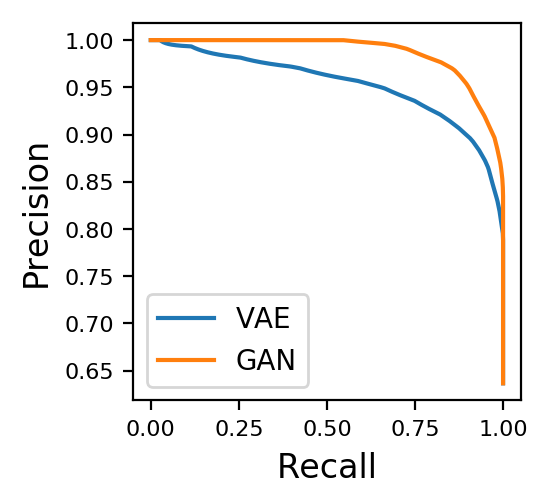

In [25]:
fig = plt.figure(figsize=(2.5, 2.5), dpi=200)
fig.add_subplot(111).tick_params(
    axis='both', which='major', labelsize=8
)
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.plot(data_for_plots[0],  data_for_plots[1],  label = "VAE")
plt.plot(data_for_plots2[0], data_for_plots2[1], label = "GAN")
plt.legend();

**What curves were obtained for the first(VAE) and the second(GAN) models? What can we say about the advantages and disadvantages of each model?**

**Type your answer below**

---
From the plot above we can conclude that GAN outperforms VAE at all recall values. GAN's curve is closer to top right, its AUC is greater, and hence, it might be better in practice (the judgement based on the plot only)


## Bonus: about features' space##

It is possible to transfer the picture-> embedding, for example, using the 1st part of the Inception network as a feature extraxtor. This embedding can be used for bin counts also

In [26]:
# if you came here and still alive, the implementation of idea above will give you extra points =)